# Traffic Pattern in HCMC

## Introduction ℹ️
Traffic Pattern in HCMC is a machine learning project focused on predicting traffic conditions (eg: estimate speed, travel time) based on factors like time of day, weather conditions. The project applies regression as the core model (predict continous speed); behind classification converting predicted speed into category level (slow/medium/fast)

## Libraries 📚
We start with import libraries and check the versions!

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json


from pytz import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR , SVC
import matplotlib.pyplot as plt

%matplotlib inline 

print("Library verions:")
print("- numpy:", np.__version__)
print("- pandas:", pd.__version__)
print("- requests:", requests.__version__)
print("- sklearn:", sklearn.__version__)
print("- seaborn:", sns.__version__)

Library verions:
- numpy: 2.2.0
- pandas: 2.3.2
- requests: 2.32.5
- sklearn: 1.7.2
- seaborn: 0.13.2


## Data Provisioning 📦

I use free API keys from TomTom and OpenWeather for comprehensive traffic and weather data collection in Ho Chi Minh City.

Data Sources & Metrics:
- Traffic Data (TomTom API):
  - Metrics: Speed (KMPH), travel time, congestion levels
  - Zoom level: 12 for detailed road analysis

- Weather Data (OpenWeather API):
  - Current weather conditions in metric units
  - Metrics: Temperature, humidity, pressure, wind, weather descriptions

Collection Parameters:
- Time Range: September 20, 2025 (22:00) to September 30, 2025 (00:00)
- Timezone: Asia/Ho_Chi_Minh
- Locations: 5 key HCMC districts (District 1, Thu Thiem, Tan So Nhat, Binh Thanh, Phu My Hung)
- Frequency: Hourly API calls with error handling

In [5]:
# Set API key (for traffic data and weather data)
TOMTOM_API_KEY = os.environ.get("TOMTOM_API_KEY")
OPENWEATHER_API_KEY = os.environ.get("OPENWEATHER_API_KEY")
# Coordinates for key locations (latitude, longitude) in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

hcmc_tz = timezone("Asia/Ho_Chi_Minh")

# Set time range for data generation
start_date = datetime(2025, 9, 20, 22, 0, 0, tzinfo=hcmc_tz) 
end_date = datetime(2025, 9, 30, 0, 0, 0, tzinfo=hcmc_tz)
# end_date = datetime.now(hcmc_tz) 

# Generate list of hourly timestamps
timestamps = []
current_time = start_date
while current_time <= end_date:
    timestamps.append(current_time)
    current_time += timedelta(hours=1)

print("HCMC Timezone:", hcmc_tz)
print("Start date (HCMC):", start_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print("End date (HCMC):", end_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print(f"Collecting data for {len(timestamps)} hourly intervals...")

HCMC Timezone: Asia/Ho_Chi_Minh
Start date (HCMC): 2025-09-20 22:00:00 LMT+0707
End date (HCMC): 2025-09-30 00:00:00 LMT+0707


In [6]:
# Function to get traffic data from TomTom API
def get_traffic_data(lat, lon, api_key, timestamp):
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    params = {
        'point': f"{lat},{lon}",
        'unit': 'KMPH',
        'key': api_key,
        'zoom': 12
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching traffic data for {lat},{lon} at {timestamp}: {e}")
        return None

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, timestamp):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching weather data for {lat},{lon} at {timestamp}: {e}")
        return None


## 🔄 Process and Merge Datasets

Let's combine two datasets by location and timestamp to study how weather affects traffic speed.

**Data Processing Pipeline:**

1. **Traffic Data Processing:**
   - Extracts key metrics: current speed, free-flow speed, confidence score, ...
   - Calculates congestion level as percentage ratio

2. **Weather Data Processing:**
   - Gets temperature and humidity, measures rainfall and wind speed
   - Uses same units for all weather data

3. **Data Integration:**
   - Merges traffic and weather information matching by time and location
   - Keeps all traffic data and adds weather details

4. **Feature Engineering:**
   - Extracts temporal features: hour, month, day of week
   - Creates binary indicators: weekend, rush hour (7-9 AM, 4-7 PM)

In [14]:
# Function to process traffic data
def process_traffic_data(traffic_data_dict, location_name, timestamp):
    processed_data = []
    if traffic_data_dict and 'flowSegmentData' in traffic_data_dict:
        segment = traffic_data_dict['flowSegmentData']
        processed_data.append({
            'Location': location_name,
            'Timestamp': timestamp,
            'Current_Speed': segment.get('currentSpeed', 0),
            'Free_Flow_Speed': segment.get('freeFlowSpeed', 0),
            'Confidence': segment.get('confidence', 0),
            'Congestion_Level': segment.get('currentTravelTime', 0) / segment.get('freeFlowTravelTime', 1) * 100,
            'Road_Closure': segment.get('roadClosure', False)
        })
    return processed_data

# Function to process weather data
def process_weather_data(weather_data_dict, timestamp):
    if weather_data_dict and 'main' in weather_data_dict:
        return {
            'Timestamp': timestamp,
            'Temperature': weather_data_dict['main'].get('temp', 0),
            'Humidity': weather_data_dict['main'].get('humidity', 0),
            'Wind_Speed': weather_data_dict['wind'].get('speed', 0) if 'wind' in weather_data_dict else 0,
            'Rainfall': weather_data_dict['rain']['1h'] if 'rain' in weather_data_dict and '1h' in weather_data_dict['rain'] else 0
        }
    return None

# Collect and process data for each hour
all_traffic_data = []
all_weather_data = []

for timestamp in timestamps:
    print(f"\nCollecting data for {timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}...")
    
    # Collect traffic data
    traffic_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching traffic data for {name}...")
        data = get_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY, timestamp)
        if data:
            traffic_data[name] = data
        time.sleep(1) 
    
    # Collect weather data
    weather_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching weather data for {name}...")
        data = get_weather_data(coords["lat"], coords["lon"], OPENWEATHER_API_KEY, timestamp)
        if data:
            weather_data[name] = data
        time.sleep(1) 
    
    # Process traffic data
    for name, data in traffic_data.items():
        processed_traffic = process_traffic_data(data, name, timestamp)
        all_traffic_data.extend(processed_traffic)
    
    # Process weather data
    for name, data in weather_data.items():
        processed_weather = process_weather_data(data, timestamp)
        if processed_weather:
            processed_weather['Location'] = name
            all_weather_data.append(processed_weather)

# Create DataFrames
traffic_df = pd.DataFrame(all_traffic_data)
weather_df = pd.DataFrame(all_weather_data)

# Merge datasets on Timestamp and Location
if not traffic_df.empty and not weather_df.empty:
    merged_df = pd.merge(
        traffic_df,
        weather_df,
        on=['Timestamp', 'Location'],
        how='left'
    )
else:
    merged_df = traffic_df if not traffic_df.empty else weather_df

# Add time-based features
if not merged_df.empty:
    merged_df['Hour'] = merged_df['Timestamp'].dt.hour
    merged_df['Month'] = merged_df['Timestamp'].dt.month
    merged_df['Day_of_Week'] = merged_df['Timestamp'].dt.dayofweek
    merged_df['Is_Weekend'] = (merged_df['Day_of_Week'] >= 5).astype(int)
    merged_df['Is_Rush_Hour'] = (
        ((merged_df['Hour'] >= 7) & (merged_df['Hour'] <= 9)) |
        ((merged_df['Hour'] >= 16) & (merged_df['Hour'] <= 19))
    ).astype(int)

# Display the data
print("\nFull Hourly Data:")
print(merged_df.to_string(index=False))
merged_df.sample(15)





























































































































































































































Full Hourly Data:
    Location                 Timestamp  Current_Speed  Free_Flow_Speed  Confidence  Congestion_Level  Road_Closure  Temperature  Humidity  Wind_Speed  Rainfall  Hour  Month  Day_of_Week  Is_Weekend  Is_Rush_Hour
  District_1 2025-09-20 21:53:00+07:00             15               25           1        166.666667         False        30.53        72        3.09         0    21      9            5           1             0
   Thu_Thiem 2025-09-20 21:53:00+07:00             40               40           1        100.000000         False        31.16        71        2.24         0    21      9            5           1             0
Tan_Son_Nhat 2025-09-20 21:53:00+07:00             31               31           1        100.000000         False        32.0

,Location,Timestamp,Current_Speed,Free_Flow_Speed,Confidence,Congestion_Level,Road_Closure,Temperature,Humidity,Wind_Speed,Rainfall,Hour,Month,Day_of_Week,Is_Weekend,Is_Rush_Hour
591,Thu_Thiem,2025-09-25 19:53:00+07:00,40,40,1,100.000000,False,31.72,70,3.60,0,19,9,3,0,1
901,Thu_Thiem,2025-09-28 09:53:00+07:00,40,40,1,100.000000,False,31.16,72,3.60,0,9,9,6,1,1
194,Phu_My_Hung,2025-09-22 11:53:00+07:00,34,41,1,120.604703,False,31.73,70,1.79,0,11,9,0,0,0
509,Phu_My_Hung,2025-09-25 02:53:00+07:00,33,42,1,127.293578,False,31.73,69,1.54,0,2,9,3,0,0
393,Binh_Thanh,2025-09-24 03:53:00+07:00,24,33,1,137.563452,False,31.72,69,1.54,0,3,9,2,0,0
933,Binh_Thanh,2025-09-28 15:53:00+07:00,22,32,1,145.812808,False,31.16,73,3.60,0,15,9,6,1,0
542,Tan_Son_Nhat,2025-09-25 09:53:00+07:00,31,31,1,100.000000,False,32.01,62,1.54,0,9,9,3,0,1
691,Thu_Thiem,2025-09-26 15:53:00+07:00,40,40,1,100.000000,False,31.72,70,3.60,0,15,9,4,0,0
582,Tan_Son_Nhat,2025-09-25 17:53:00+07:00,31,31,1,100.000000,False,32.01,62,3.60,0,17,9,3,0,1
414,Phu_My_Hung,2025-09-24 07:53:00+07:00,33,41,1,124.300112,False,31.73,69,1.54,0,7,9,2,0,1


Due to the long waiting time for loading and getting data from API, therefore I save this merged dataset into CSV and easy load it for reusing. 

In [2]:
# Save merged dataset to CSV
print("Saving processed data to CSV...")
output_file = "traffic_weather_data.csv"
merged_df.to_csv(output_file, index=False)
print(f"\nDataset saved to {output_file}")

Saving processed data to CSV...


NameError: name 'merged_df' is not defined

# 📃 Sample the data

Here a random sample of traffic and weather features taken from the merged dataset to see what the difference numbers based on the locations and exact timestamp.

In [7]:
# Load dataset from CSV
input_file = "traffic_weather_data.csv"
merged_df = pd.read_csv(input_file)
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

print("\nLoaded Data Sample:")
merged_df.sample(10)


Loaded Data Sample:


,Location,Timestamp,Current_Speed,Free_Flow_Speed,Confidence,Congestion_Level,Road_Closure,Temperature,Humidity,Wind_Speed,Rainfall,Hour,Month,Day_of_Week,Is_Weekend,Is_Rush_Hour
930,District_1,2025-09-28 15:53:00+07:00,14,26,1,187.096774,False,31.10,73,3.60,0,15,9,6,1,0
799,Phu_My_Hung,2025-09-27 12:53:00+07:00,31,42,1,135.435780,False,31.17,72,3.60,0,12,9,5,1,0
684,Phu_My_Hung,2025-09-26 13:53:00+07:00,33,42,1,127.293578,False,31.73,70,3.60,0,13,9,4,0,0
327,Tan_Son_Nhat,2025-09-23 14:53:00+07:00,31,31,1,100.000000,False,32.01,62,1.54,0,14,9,1,0,0
639,Phu_My_Hung,2025-09-26 04:53:00+07:00,33,41,1,124.300112,False,31.73,70,3.60,0,4,9,4,0,0
376,Thu_Thiem,2025-09-24 00:53:00+07:00,40,40,1,100.000000,False,31.72,69,1.54,0,0,9,2,0,0
952,Tan_Son_Nhat,2025-09-28 19:53:00+07:00,31,31,1,100.000000,False,32.01,62,3.60,0,19,9,6,1,1
642,Tan_Son_Nhat,2025-09-26 05:53:00+07:00,31,31,1,100.000000,False,32.01,62,3.60,0,5,9,4,0,0
1052,Tan_Son_Nhat,2025-09-29 15:53:00+07:00,31,31,1,100.000000,False,32.01,62,3.60,0,15,9,0,0,0
280,District_1,2025-09-23 05:53:00+07:00,8,27,1,343.333333,False,31.66,70,1.79,0,5,9,1,0,0


## 🔍 Data analysis (Explanatory)
### 🧹 Missing Values & Duplicates

In [77]:
# Missing values
print("Missing values per column:\n", merged_df.isnull().sum())

# Check duplicates
print("Duplicate rows:", merged_df.duplicated().sum())


Missing values per column:
 Location            0
Timestamp           0
Current_Speed       0
Free_Flow_Speed     0
Confidence          0
Congestion_Level    0
Road_Closure        0
Temperature         0
Humidity            0
Wind_Speed          0
Rainfall            0
Hour                0
Month               0
Day_of_Week         0
Is_Weekend          0
Is_Rush_Hour        0
dtype: int64
Duplicate rows: 0


### 📊 Descriptive Statistics

In [78]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current_Speed,1095.0,27.515068,10.351302,5.00,21.00,31.000000,34.000000,42.000000
Free_Flow_Speed,1095.0,34.203653,6.019437,24.00,31.00,33.000000,40.000000,43.000000
Confidence,1095.0,1.000000,0.000000,1.00,1.00,1.000000,1.000000,1.000000
Congestion_Level,1095.0,152.628349,91.367809,100.00,100.00,124.300112,150.253807,568.965517
Temperature,1095.0,31.624776,0.334581,30.53,31.17,31.720000,31.730000,32.270000
Humidity,1095.0,68.817352,3.627726,62.00,69.00,70.000000,71.000000,73.000000
Wind_Speed,1095.0,2.656000,0.952746,1.54,1.79,3.090000,3.600000,3.600000
Rainfall,1095.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000
Hour,1095.0,11.643836,6.985955,0.00,6.00,12.000000,18.000000,23.000000
Month,1095.0,9.000000,0.000000,9.00,9.00,9.000000,9.000000,9.000000


### 📊 Feature Selection and Correlation Analysis

To identify the most relevant predictors for **traffic speed**, we examined the relationships between features and the target variable (`Current_Speed`).


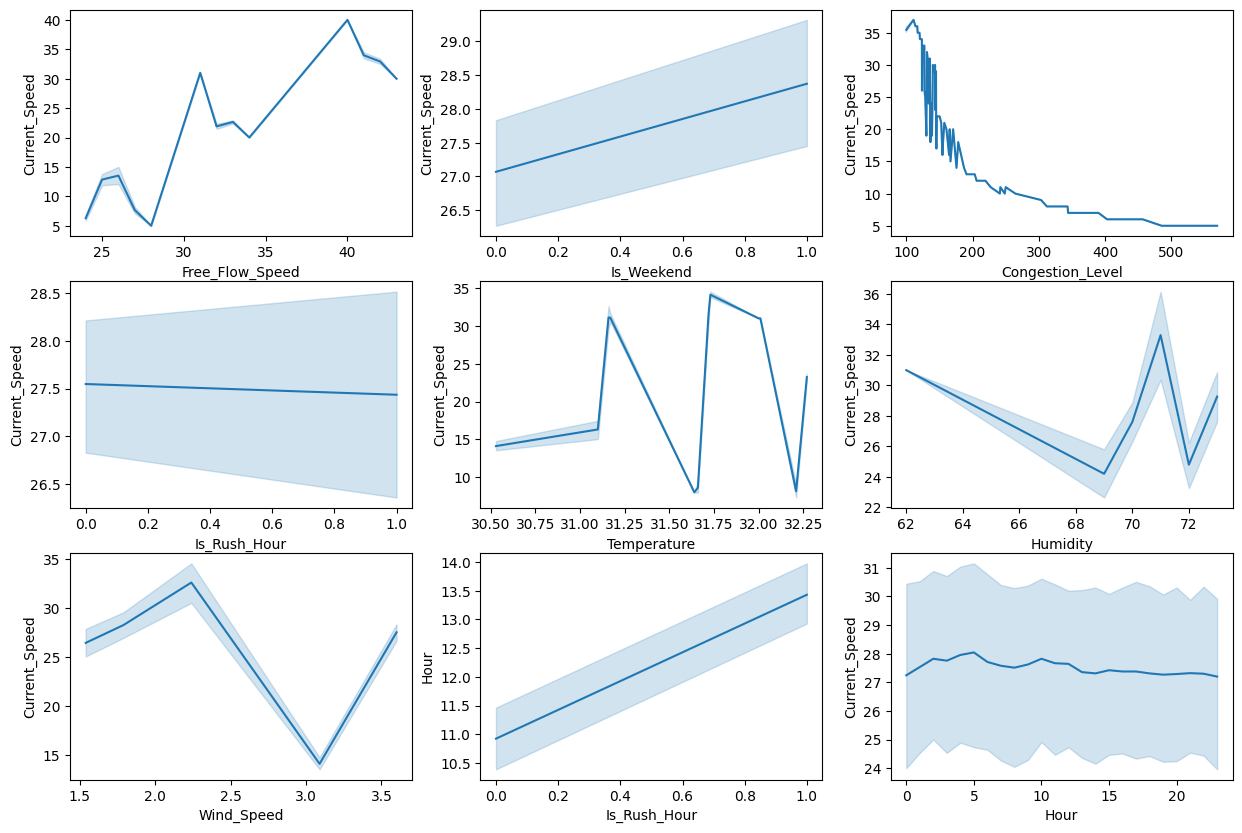

In [18]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.lineplot(data=merged_df, x='Free_Flow_Speed', y='Current_Speed')

plt.subplot(3, 3, 2)
sns.lineplot(data=merged_df, x='Is_Weekend', y='Current_Speed')

plt.subplot(3,3 , 3)    
sns.lineplot(data=merged_df, x='Congestion_Level', y='Current_Speed')

plt.subplot(3, 3, 4)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Current_Speed')

plt.subplot(3, 3, 5)
sns.lineplot(data=merged_df, x='Temperature', y='Current_Speed')

plt.subplot(3, 3, 6)
sns.lineplot(data=merged_df, x='Humidity', y='Current_Speed')

plt.subplot(3, 3, 7)
sns.lineplot(data=merged_df, x='Wind_Speed', y='Current_Speed')

plt.subplot(3, 3, 8)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Hour')

plt.subplot(3, 3, 9)
sns.lineplot(data=merged_df, x='Hour', y='Current_Speed')   

plt.show()


Line plots illustrate how Current_Speed varies with individual features like Free_Flow_Speed, Congestion_Level, Temperature, Humidity, and categorical variables such as Is_Weekend and Is_Rush_Hour. 

For instance, Free_Flow_Speed shows a strong positive relationship with Current_Speed, while Congestion_Level has a strong negative relationship. Weather features like Temperature, Humidity, and Wind_Speed exhibit weaker but still notable effects.

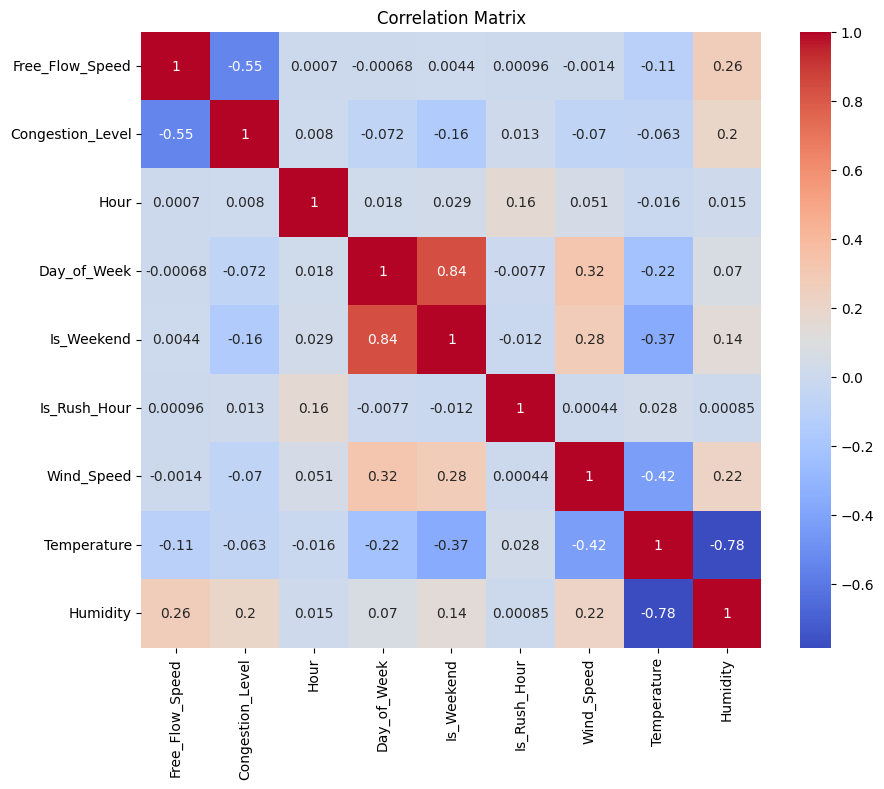

In [8]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature','Humidity'
]
target = 'Current_Speed'
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix")
# corr_matrix = merged_df[features + [target]].corr()
# print(corr_matrix['Current_Speed'].sort_values(ascending=False))
corr_matrix = merged_df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


Current_Speed       1.000000
Free_Flow_Speed     0.817374
Temperature         0.099907
Is_Weekend          0.059679
Day_of_Week         0.028254
Wind_Speed         -0.000128
Is_Rush_Hour       -0.004923
Hour               -0.015372
Humidity           -0.131811
Congestion_Level   -0.819889
Name: Current_Speed, dtype: float64


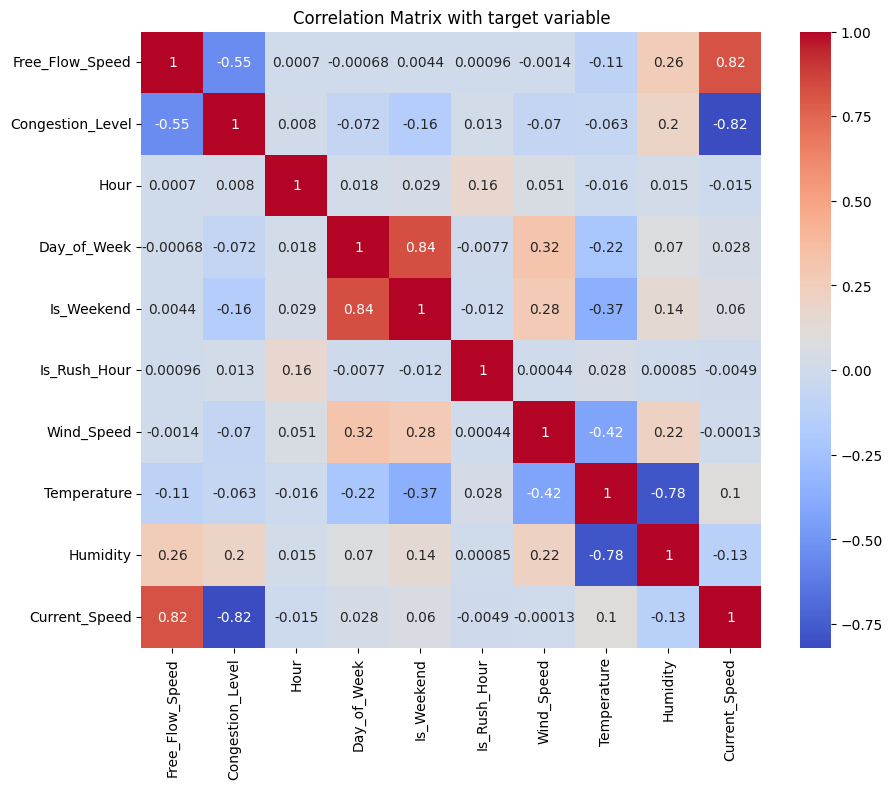

In [9]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature','Humidity'
]
target = 'Current_Speed'
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix with target variable")
corr_matrix = merged_df[features + [target]].corr()
print(corr_matrix['Current_Speed'].sort_values(ascending=False))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


The correlation matrix reveals several key points and offers a comprehensive view of feature relationships

It showing that Free_Flow_Speed is highly positively correlated with Current_Speed (0.82), while Congestion_Level is strongly negatively correlated (-0.82). 

Other features like Humidity, Is_Weekend, and Is_Rush_Hour display moderate to low correlations. 

In conclusion, the strongest predictors for Current_Speed are Free_Flow_Speed and Congestion_Level. Temporal features such as Hour, Day_of_Week, Is_Weekend, and Is_Rush_Hour provide useful contextual patterns. Environmental factors like Temperature, Humidity, and Wind_Speed may indirectly influence traffic and should be included for model robustness. 

These insights support the chosen feature set: 

`['Free_Flow_Speed', 'Congestion_Level', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Humidity']`

## ⚙️ Preprocessing data


### Target variable 🎯
It is clear that Current_Speed is the target, while the features combines datatime variables, traffic features that the Correlation Matrix and Lineplots showed the highest correlation with them. 

In [10]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Rainfall','Humidity'
]
target = 'Current_Speed'

X = merged_df[features] 
y = merged_df[target]   


### 🪓 Splitting into train/test

Before the model can be trained, we will use 80% of the data available, and the other 20% is used to ask it to predict the target variable for. Because the true target variable of that 20% is known, we can compare the predictions with the ground truth and devise how well the model performs.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 1095 observations, of which 766 are now in the train set and 329 in the test set.


### 🧬 Modelling

For traffic speed prediction, it is crucial to balance accuracy with generalization. To address this, I consider both **Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)**:  
- MAE gives a direct measure of average prediction error.  
- MSE penalizes larger errors more heavily, which is important when predicting traffic patterns during peak hours or extreme congestion events.  

Below is an explanation of why each regression model I used could be helpful in this problem:


**Linear Regression**
- Why helpful: Provides a simple, interpretable baseline. Useful to check if traffic speed can be reasonably explained by a linear combination of features (like free-flow speed, congestion level, or weather).  
- Limitations: Struggles with non-linear relationships common in traffic data (e.g., sudden drops during accidents or rush hours).


**KNN Regression**
- Why helpful: Captures **local patterns** in the data by using nearby observations. Effective when traffic patterns are strongly dependent on similar past conditions.  
- Limitations: Sensitive to scaling of features and computationally expensive for large datasets. Performance depends heavily on the choice of `k`.


**Decision Tree Regression**
- Why helpful: Handles **non-linear relationships** and interactions well (e.g., congestion + rush hour combined). Easy to visualize and interpret.  
- Limitations: Tends to **overfit** if not properly pruned or regularized, especially in small datasets.


**Support Vector Regression (SVR)**
- Why helpful: Uses kernel methods to model complex, non-linear relationships between traffic and influencing factors (e.g., weather, time of day). Robust to outliers.  
- Limitations: Requires careful tuning of parameters (`C`, `gamma`). Can be slow on large datasets.

By comparing these models, I can identify not only the best-performing predictor but also gain insights into the nature of traffic speed patterns in relation to temporal, congestion, and weather-related factors.

In [12]:
models = {
    'Linear Regression': LinearRegression(), 
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regression': DecisionTreeRegressor(max_depth=5, random_state=42), 
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
}


model_result = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    model_result.append((name, mae, mse, r2))

model_result = pd.DataFrame(model_result, columns=["Model", "MAE", "MSE", "R²"])
model_result = model_result.sort_values("R²")

model_result

,Model,MAE,MSE,R²
0,Linear Regression,2.631297,10.702216,0.899176
3,SVR,0.890016,4.548275,0.957151
2,Decision Tree Regression,0.215019,0.265527,0.997499
1,KNeighborsRegressor,0.225532,0.242796,0.997713


KNN Regressor: MAE=0.226, MSE=0.24, R²=0.99 -> very small error and near-perfect fit between predict and actual. Shows that local similarity patterns in your dataset (similar traffic conditions → similar speeds) are highly predictive.

DecisionTree Regression: MAE=0.215, MSE=0.266, R² = 0.997 -> also an excellent fit, with errors almost as small as KNN. Strong at capturing non-linear patterns (e.g., congestion during rush hour).

Support Vector Regression (SVR): MAE = 0.890, MSE = 4.548, R² = 0.957 -> performs well overall but not as strong as KNN or Decision Tree. Captures non-linear trends, but requires fine-tuning; otherwise, errors can be higher.

Linear Regression: MAE = 2.631, MSE = 10.702, R² = 0.899 -> the weakest performer here. Struggles because traffic speed is influenced by complex, non-linear interactions (rush hours, weather, congestion), which a simple linear model cannot capture well.

**Best Model**

KNN and Decision Tree, both achieving very low error and R² ~0.998.


### ❌Cross-Validation + Hyperparameter 

Cross-validation avoids a particular train-test split, and produces a more realistic overall model score. 

In [14]:
# the higher the R-squared, the better the model fits your data.​
num_folds= 5 # Define the number of folds for cross-validation
cv = KFold(n_splits=5,shuffle=True, random_state=42 )

# Model 1: Linear Regression 
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring='r2')
print("-- Linear Regression (R²):")
for i, score in enumerate(lin_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Mean R²: {lin_scores.mean()*100:.2f}%\n")

# Model 2: SVR (with GridSearch) 
svr = SVR(kernel='rbf')
param_grid = {'C':[1, 10, 100], 'gamma':['scale', 0.1]}
svr_grid = GridSearchCV(svr, param_grid=param_grid, cv=cv, scoring='r2')
svr_grid.fit(X, y)
print("-- SVR (R²):")
print("Best Params:", svr_grid.best_params_)
best_svr = svr_grid.best_estimator_
svr_scores = cross_val_score(best_svr, X, y, cv=cv, scoring='r2')
for i, score in enumerate(svr_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Best CV R²: {svr_grid.best_score_*100:.2f}%\n")

# Model 3: Decision Tree Regressor 
dt = DecisionTreeRegressor(random_state=42)
params = {'max_depth':[3, 5, 7, 10, None],
          'min_samples_split':[2, 5, 10]}
grid = GridSearchCV(dt, params, cv=cv, scoring='r2')
grid.fit(X, y)
dt_predict = grid.best_estimator_.predict(X_test)
print("-- Decision Tree (R²):")
print("Best Params:", grid.best_params_)
best_dt = grid.best_estimator_
dt_scores = cross_val_score(best_dt, X, y, cv=cv, scoring='r2')
for i, score in enumerate(dt_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Best CV R²: {grid.best_score_*100:.2f}%\n")

-- Linear Regression (R²):
  Fold 1: 89.87%
  Fold 2: 90.65%
  Fold 3: 90.04%
  Fold 4: 90.34%
  Fold 5: 90.28%
Mean R²: 90.24%

-- SVR (R²):
Best Params: {'C': 100, 'gamma': 'scale'}
  Fold 1: 99.95%
  Fold 2: 99.95%
  Fold 3: 99.97%
  Fold 4: 99.97%
  Fold 5: 99.94%
Best CV R²: 99.95%

-- Decision Tree (R²):
Best Params: {'max_depth': 10, 'min_samples_split': 2}
  Fold 1: 99.98%
  Fold 2: 100.00%
  Fold 3: 100.00%
  Fold 4: 100.00%
  Fold 5: 100.00%
Best CV R²: 99.99%



The cross-validation results show that all three models perform strongly, but with some different points.

Linear Regression: achieved a mean R² of about 90.24% which is solid for baseline model, but it seems get struggle to capture the non-linear relationbships in traffic data. 

Support Vector Regression: with tuned parameters (C=100, gamma='scale'), performed well, reaching a mean R² of around 99.95% - its better balance between accuracy and generalization.

Decision Tree: achieved an almost perfect with a best mean R² 99.99%, captured nearly all variance in the data. The higher the R-squared, the better the model fits your data.​ However, extremely high scores may get overfitting. 

**Best model**: Decision Tree

### ⚖️Compare Models With Actual vs Predicted

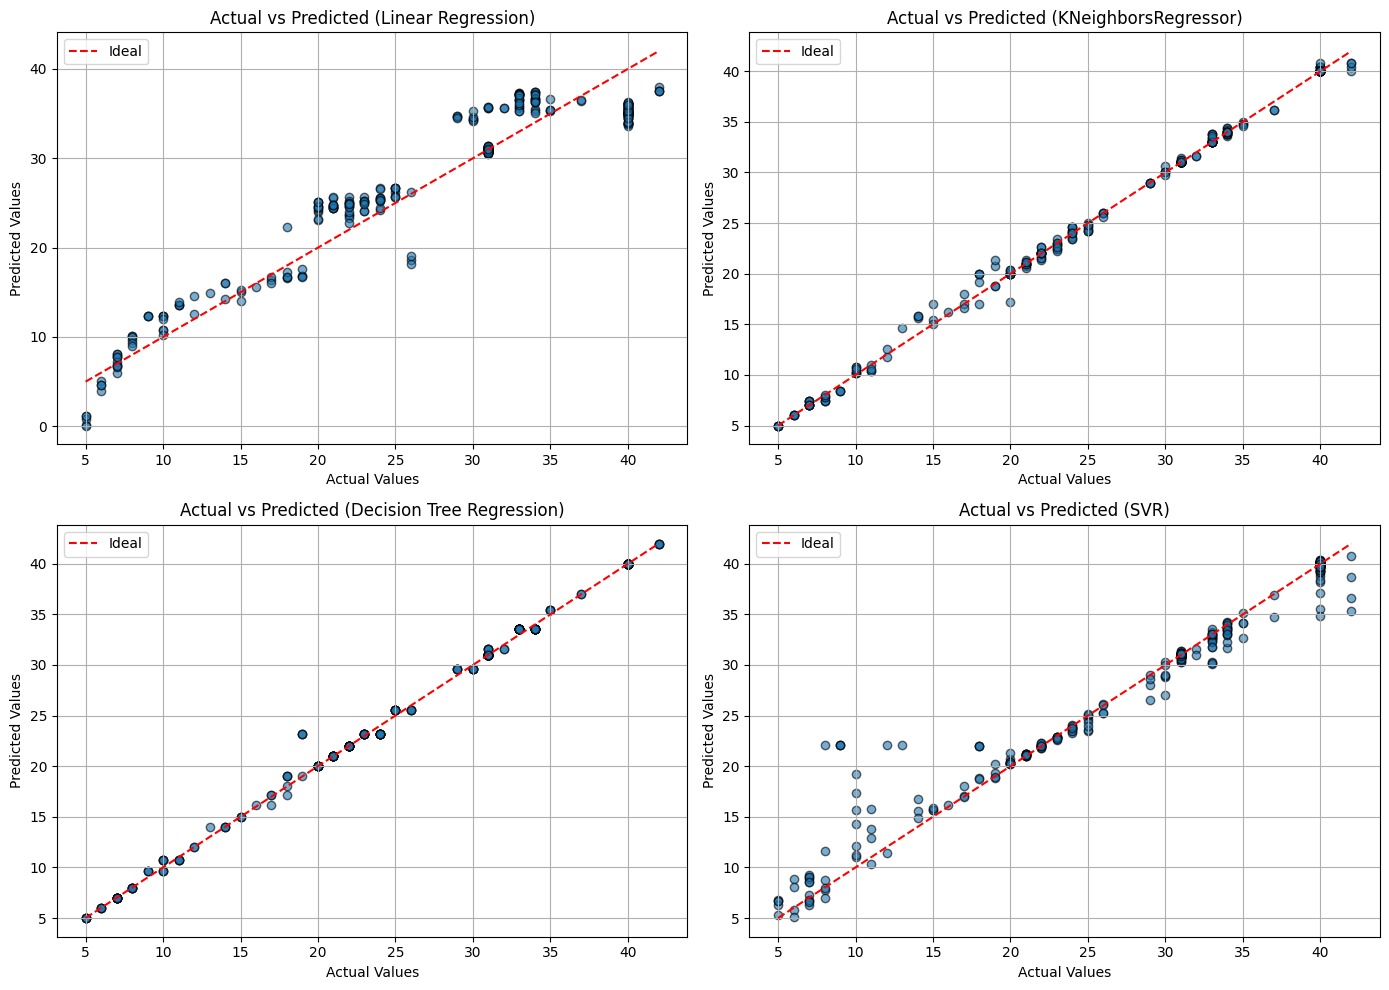

In [15]:
plt.figure(figsize=(14, 10))
models = {
    'Linear Regression': LinearRegression(), 
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regression': DecisionTreeRegressor(max_depth=5, random_state=42), 
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
}


for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    plt.subplot(2, 2, i)
    plt.scatter(y_test, preds, alpha=0.6, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r--", label="Ideal")
    plt.title(f"Actual vs Predicted ({name})")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


The Actual vs Predicted plots clearly highlight the differences in performance across models. 

Linear Regression shows a reasonable fit but often missed the real values, especially in the middle range, meaning it cannot fully capture the patterns in traffic data

KNN Regressor and Decision Tree Regression both perform exceptionally well, with predictions almost perfectly aligned with the ideal line, showing they can learn the complex patterns in the data. 

SVR also demonstrates strong performance, closely following the ideal line, though with slightly more spread in certain ranges compared to KNN and Decision Tree. 

Overall, the visualization confirms that non-linear models (KNN, Decision Tree, SVR) are far superior to Linear Regression in predicting traffic speed, with Decision Tree and KNN delivering the most accurate predictions.

**Best model**: Decision Tree and KNN

### 🔍Feature Importance and Permutation Importance

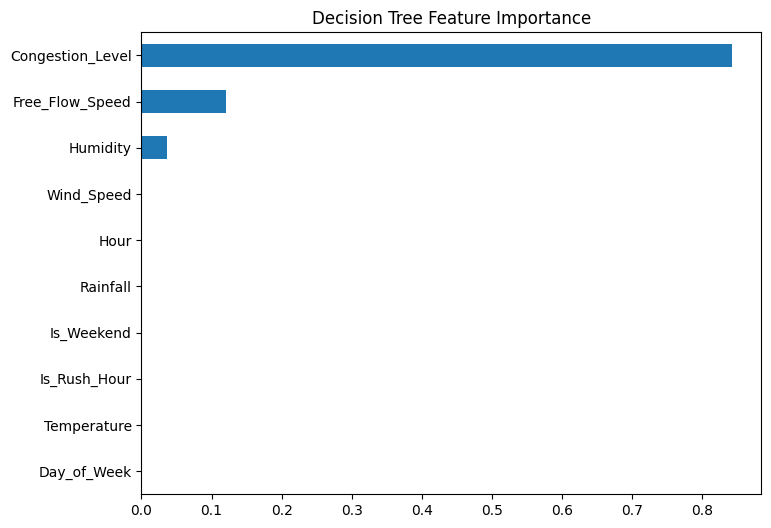

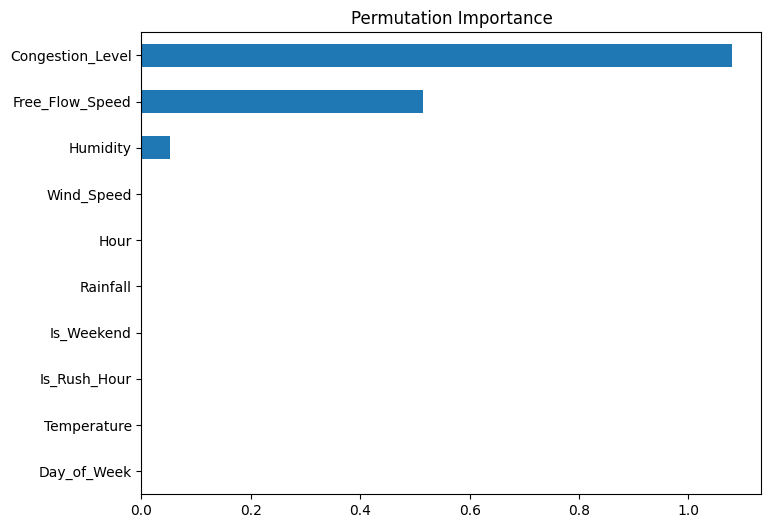

In [16]:
plt.figure(figsize=(8,6))
dt_model = grid.best_estimator_
importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Decision Tree Feature Importance")

result = permutation_importance(dt_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(result.importances_mean, index=X_test.columns)
perm_importances = perm_importances.sort_values(ascending=True)
plt.figure(figsize=(8,6))
perm_importances.plot(kind='barh')
plt.title("Permutation Importance")

plt.show()

The feature importance and permutation importance results both show that Congestion_Level is the most influential factor in predicting traffic speed, followed by Free_Flow_Speed, while other features such as humidity, temperature, wind speed, and time-related variables seems not contribute.

The decision tree feature importance reflects how much each feature reduces error within the model, while permutation importance provides a more realistic view by measuring the drop in performance when each feature is shuffled. Since both methods highlight the same top two features, we can conclude that traffic speed in this dataset is mainly driven by congestion and free-flow speed, with weather and temporal features playing only a minor role.

## 🕒 Applied ML model into predicting


In [17]:
## Predict speed with exact lodation and timestamp 
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(kernel='rbf')
}

model_list ={}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_list[name] = {'MSE': mse, 'MAE': mae}

loc_name = 'District_1'
distance_km = 5.0
loc_timestamp = pd.Timestamp(datetime(2025, 9, 29, 9, 0), tz='Asia/Ho_Chi_Minh') 

df_loc = merged_df[merged_df['Location'] == loc_name].copy()
if df_loc.empty:
    print(f"\nError: No data for location '{loc_name}'.")
else: 
    df_loc['time_diff'] = (df_loc['Timestamp'] - loc_timestamp).abs() # using abs() for making sure the result is positive (not -15min)

    X_pred = pd.DataFrame([df_loc.loc[df_loc['time_diff'].idxmin(), features].to_dict()])
    X_pred = X_pred.fillna(0)

    print(f"\nPredicted Speeds and Travel time for {loc_name} at {loc_timestamp}:")
    for name, model in models.items():
        predicted_speed = model.predict(X_pred)[0]
        if predicted_speed > 0:
            travel_time = (distance_km / predicted_speed) * 60
            print(f"{name}: {predicted_speed:.2f} km/h | Travel Time: {travel_time:.1f} min")





Predicted Speeds and Travel time for District_1 at 2025-09-29 09:00:00+07:00:
Linear Regression: 15.42 km/h | Travel Time: 19.5 min
Decision Tree: 17.00 km/h | Travel Time: 17.6 min
SVM: 22.32 km/h | Travel Time: 13.4 min


The prediction results for District 1 at 9:00am on 29 Sepetember 2025 show some variation across models. Linear Regression estimated the lowest speed at 15.42 km/h, while the Decision Tree predicted a slightly higher value of 17.00 km/h. The SVM model produced the highest estimate at 22.32 km/h, reflecting its ability to capture more complex, non-linear patterns. These differences highlight how model choice can influence predictions: simpler models like Linear Regression tend to underestimate traffic speed under congested conditions, while more flexible models such as Decision Tree and SVM provide higher, and potentially more realistic, estimates. 

For a 5 km journey in District 1 at 9:00 AM, the models suggest travel could take between 13.5 and 19.5 minutes, depending on the method used. The Decision Tree and SVM models give faster and likely more realistic travel estimates compared to Linear Regression, which tends to underestimate speed.

Overall, this demonstrates the practical use of the models in generating traffic speed forecasts for real-world decision-making.

In [ ]:
import numpy as np
import pandas as pd
import math
from math import radians, sin, cos, asin, sqrt

# calculate great-circle distances between the two points - using the Haversine formula

def haversine(lat1, lon1, lat2, lon2):
    
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0

    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2))
    r = 6371.0
    return  2 * math.asin(math.sqrt(a)) * r

# => distance: between origin and destination to turn speed -> time

def minutes_from_speed(distance_km, speed_kmh, min_speed_kmh=3.0, calibration=1.0):
    # time = distance / speed
    eff_speed = max(float(speed_kmh), min_speed_kmh)
    minutes = (distance_km / eff_speed) * 60.0
    return minutes * calibration

# convert distance & speed into minutes =>  calibration: a safety multiplier (+10%) for junctions, signals, human behavior

def get_features_for(loc_name, when_ts, merged_df, feature_cols):
    df_loc = merged_df[merged_df['Location'] == loc_name].copy()
    if df_loc.empty:
        raise ValueError(f"No data for location '{loc_name}'.")
    idx = (df_loc['Timestamp'] - when_ts).abs().sort_values().index[0]
    row = df_loc.loc[idx]
    X_row = pd.DataFrame([row[feature_cols].to_dict()])
    return X_row, row


In [27]:
def predict_speed_kmh(model, loc_name, when_ts, merged_df, feature_cols):
    X, _ = get_features_for(loc_name, when_ts, merged_df, feature_cols)
    y_hat = model.predict(X)
    return float(y_hat[0]), X


In [28]:
def estimate_travel_time_dt(
    model, origin_name, dest_name, when_ts, merged_df, feature_cols,
    locations_dict, route_factor=1.30, time_calibration=1.10
):
    # Distances
    o = locations_dict[origin_name]; 
    d = locations_dict[dest_name]
    straight_km = haversine(o['lat'], o['lon'], d['lat'], d['lon'])
    route_km = straight_km * route_factor
    # 1.30 -> assume roads are ~30% longer than straight line

    # Predicted speeds
    v_o, Xo = predict_speed_kmh(model, origin_name, when_ts, merged_df, feature_cols)
    v_d, Xd = predict_speed_kmh(model, dest_name, when_ts, merged_df, feature_cols)
    v_avg = (v_o + v_d) / 2.0
    # predict speed at origin and destination
    # average the two speeds: Alternatives: min(v_o, v_d) for conservative estimates; or add a midpoint point later.

    # ETA: estimated time of arrival 
    eta_minutes = minutes_from_speed(route_km, v_avg, min_speed_kmh=3.0, calibration=time_calibration)
    

    result = {
        "origin": origin_name,
        "destination": dest_name,
        "timestamp_used": when_ts,
        "straight_distance_km": round(straight_km, 3),
        "estimated_route_km": round(route_km, 3),
        "pred_speed_origin_kmh": round(v_o, 2),
        "pred_speed_dest_kmh": round(v_d, 2),
        "avg_speed_kmh": round(v_avg, 2),
        "eta_minutes": round(eta_minutes, 1),
    }

    # Add global feature importance
    importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    result["global_feature_importance"] = importances.round(3).to_dict()

    return result


In [32]:
best_model = grid.best_estimator_   # replace with dt_model if you didn’t tune

hcmc_tz = timezone("Asia/Ho_Chi_Minh")
when = pd.Timestamp("2025-09-30 17:00:00", tz=hcmc_tz)

feature_cols = [   'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Rainfall','Humidity']

res_dt = estimate_travel_time_dt(
    model=best_model,
    origin_name="District_1",
    dest_name="Tan_Son_Nhat",
    when_ts=when,
    merged_df=merged_df,
    feature_cols=feature_cols,
    locations_dict=hcmc_locations,
    route_factor=1.30,
    time_calibration=1.10
)
res_dt


{'origin': 'District_1',
 'destination': 'Tan_Son_Nhat',
 'timestamp_used': Timestamp('2025-09-30 17:00:00+0700', tz='Asia/Ho_Chi_Minh'),
 'straight_distance_km': 7.133,
 'estimated_route_km': 9.272,
 'pred_speed_origin_kmh': 16.0,
 'pred_speed_dest_kmh': 31.0,
 'avg_speed_kmh': 23.5,
 'eta_minutes': 26.0,
 'global_feature_importance': {'Congestion_Level': 0.843,
  'Free_Flow_Speed': 0.121,
  'Humidity': 0.037,
  'Wind_Speed': 0.0,
  'Hour': 0.0,
  'Day_of_Week': 0.0,
  'Is_Rush_Hour': 0.0,
  'Is_Weekend': 0.0,
  'Temperature': 0.0,
  'Rainfall': 0.0}}

In [27]:
%pip install pyarrow

import joblib

joblib.dump(best_dt, "website/server/model/dt_model.pkl")

df = pd.read_csv("traffic_weather_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], utc=True).dt.tz_convert("Asia/Ho_Chi_Minh")
if "Hour" not in df:
    df["Hour"] = df["Timestamp"].dt.hour
if "Day_of_Week" not in df:
    df["Day_of_Week"] = df["Timestamp"].dt.dayofweek
if "Is_Weekend" not in df:
    df["Is_Weekend"] = df["Day_of_Week"].isin([5,6]).astype(int)
if "Is_Rush_Hour" not in df:
    df["Is_Rush_Hour"] = df["Hour"].isin([7,8,9,16,17,18]).astype(int)
# Convert Timestamp to UTC before saving to Parquet
df["Timestamp"] = df["Timestamp"].dt.tz_convert("UTC")
joblib.dump(df, "website/server/model/merged_df.pkl")

feature_cols = [
    "Free_Flow_Speed","Congestion_Level","Hour","Day_of_Week","Is_Weekend",
    "Is_Rush_Hour","Wind_Speed","Temperature","Rainfall","Humidity"
]
joblib.dump(feature_cols, "website/server/model/feature_cols.pkl")
print("Artifacts saved.")



Note: you may need to restart the kernel to use updated packages.
Artifacts saved.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
